In [1]:
%matplotlib inline

In [2]:
from kid_readout.measurement.io import nc

In [3]:
ncf = nc.NCFile('/data/readout/2016-08-15_145317_magnetic_shield_high_4.nc')

In [4]:
ncf.node_names()

[u'SweepArray0',
 u'SweepStreamArray1',
 u'ADCSnap2',
 u'SweepArray3',
 u'SweepStreamArray4',
 u'ADCSnap5',
 u'SweepArray6',
 u'SweepStreamArray7',
 u'ADCSnap8',
 u'SweepArray9',
 u'SweepStreamArray10',
 u'ADCSnap11']

In [5]:
all_ssa = [ncf.read(name) for name in ncf.node_names() if name.startswith('SweepStreamArray')]

In [6]:
all_snaps = [ncf.read(name) for name in ncf.node_names() if name.startswith('ADCSnap')]

In [7]:
from collections import namedtuple
ResonatorData = namedtuple('ResonatorData', field_names=['f_data', 's21_data',
                                                         'f_model', 's21_model',
                                                         'f_r', 's21_r'])

def extract(resonator, normalize, num_model_points):
    f_data = resonator.frequency.copy()
    s21_data = resonator.data.copy()
    f_model = np.linspace(f_data.min(), f_data.max(), num_model_points)
    s21_model = resonator.model.eval(params=resonator.current_params, f=f_model)
    f_r = resonator.f_0
    s21_r = resonator.model.eval(params=resonator.current_params, f=f_r)
    if normalize:
        s21_data = resonator.remove_background(frequency=f_data, s21_raw=s21_data)
        s21_model = resonator.remove_background(frequency=f_model, s21_raw=s21_model)
        s21_r = resonator.remove_background(frequency=f_r, s21_raw=s21_r)
    return ResonatorData(f_data, s21_data, f_model, s21_model, f_r, s21_r)

    
def amplitude(axis, resonator, normalize=False, num_model_points=1000, f_scale=1e-6, three_ticks=True, 
              data_color='blue', model_color='brown'):
    rd = extract(resonator, normalize, num_model_points)
    ax.plot(f_scale * rd.f_data, 20 * np.log10(np.abs(rd.s21_data)), '.', color=data_color, markersize=2)
    ax.plot(f_scale * rd.f_model, 20 * np.log10(np.abs(rd.s21_model)), '-', color=model_color)
    ax.plot(f_scale * rd.f_r, 20 * np.log10(np.abs(rd.s21_r)), '.', color=model_color, markersize=3)
    if three_ticks:
        ax.set_xticks(f_scale * np.array([rd.f_data.min(), rd.f_r, rd.f_data.max()]))


In [8]:
plt.rcParams['font.size'] = 7

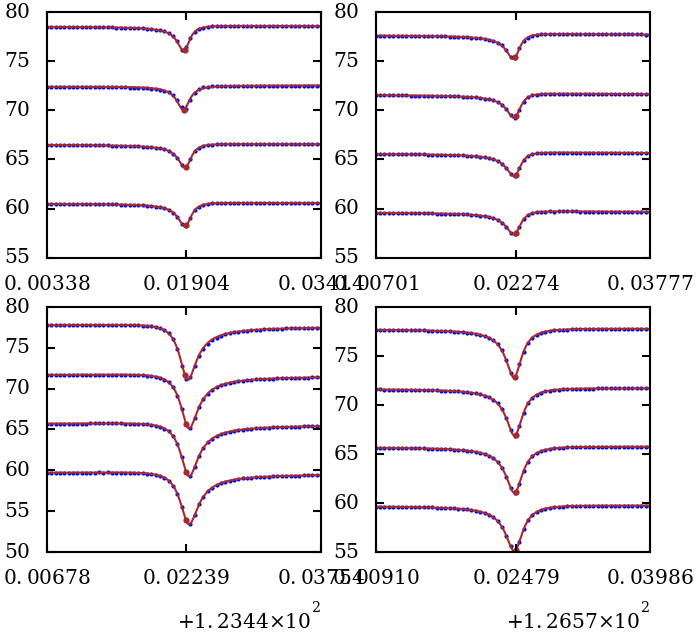

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(3, 3))
for index, ax in enumerate(axes.flatten()):
    for ssa in all_ssa:
        amplitude(ax, ssa[index].resonator)

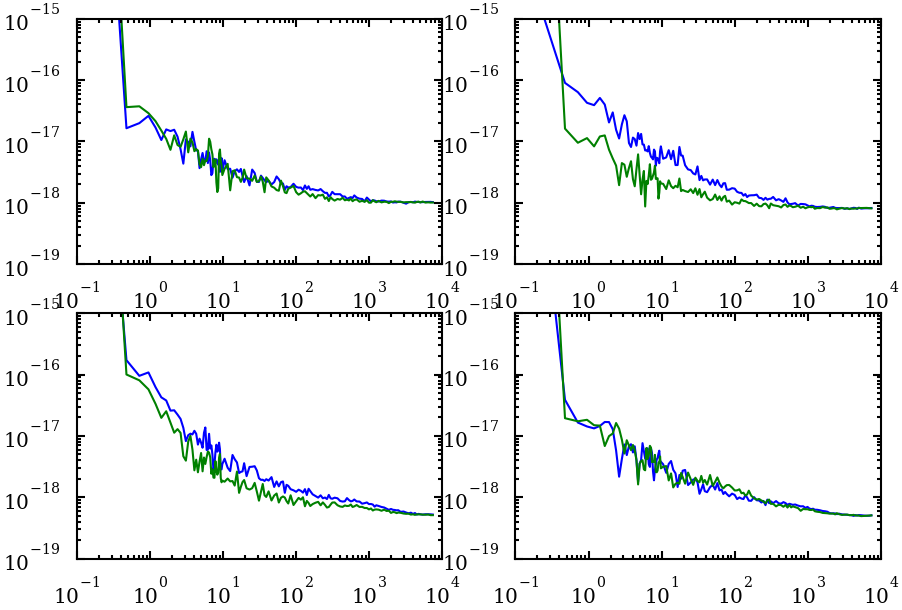

In [10]:
attenuation_index = 0

fig, axes = plt.subplots(2, 2, figsize=(4, 3))
for index, ax in enumerate(axes.flatten()):
    sss = all_ssa[attenuation_index][index]
    sss.set_S(window=plt.mlab.window_hanning)
    ax.loglog(sss.S_frequency, sss.S_xx, '-b')
    ax.loglog(sss.S_frequency, sss.S_yy, '-g')
    ax.set_ylim(1e-19, 1e-15);

In [11]:
[snap.x.ptp() for snap in all_snaps]

[102.0, 59.0, 43.0, 31.0]

In [12]:
[snap.y.ptp() for snap in all_snaps]

[37.0, 49.0, 45.0, 43.0]

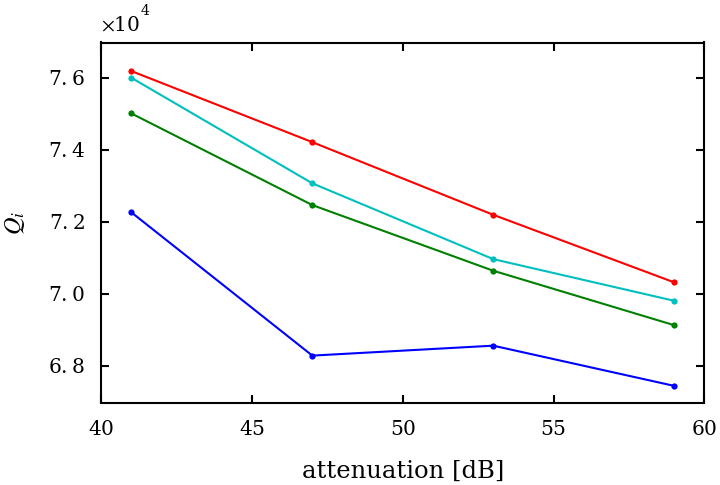

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('attenuation [dB]')
ax.set_ylabel('$Q_i$')

for index in range(4):
    ax.plot([ssa[index].stream.roach_state.dac_attenuation for ssa in all_ssa],
            [ssa[index].resonator.Q_i for ssa in all_ssa],
            '.-')